## Libraries

In [149]:
# libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

## Calculate some stuff

In [150]:
# get nytimes covid data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, error_bad_lines=False)

# pivot data from long to wide
df = df.pivot(index='date', columns='state', values='cases')

# clean up the data so blanks are zeros and numbers are integers
df = df.fillna(0)
df = df.astype(int)

# reset index (to make graph work)
df = df.reset_index()

# drop most recent date's data (some data doesn't get updated at the same time and it sckews the numbers)
df.drop(df.tail(1).index,inplace=True)

# drop territories (if you want to include territories, comment out this line and below)
df.drop(['Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands'], axis=1, inplace=True)

# get population data from wikipedia
WIKI_URL = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"
df_pop = pd.read_html(WIKI_URL, header=0)

# fix the dataframe, it ends up inside a list for some reason
df_pop = df_pop[0]

# delete all the columns execpt for "Population estimate, July 1, 2019[2]" and "State"
for columns in df_pop.columns:
   if columns not in ["Population estimate, July 1, 2019[2]", "State"]:
      df_pop.drop([columns], axis=1, inplace=True)

# Rename "Population estimate, July 1, 2019[2]" to "Population"
df_pop.rename(columns={"Population estimate, July 1, 2019[2]": "Population"}, inplace=True)

# Drop the terretories and totals, etc (If you want to include territories, comment out this line)
df_pop.drop([31, 52, 53, 54, 55, 56, 57, 58, 59], inplace=True)

# sort list alphabetically by state name
df_pop = df_pop.sort_values("State")
df_pop = df_pop.reset_index()
df_pop.drop(["index"], axis=1, inplace=True)
df_pop.set_index("State", inplace=True)


# Make dataframe for total cases
df_total = df.copy()

# Make dataframe for cases per captia
df_total_percapita = df.copy()
for c in df_total_percapita.columns:
    if c in ['date', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']:
        pass
    else:
        df_total_percapita[c] = df_total_percapita[c]/df_pop['Population'][c]*100000

# Make dataframe for DELTA (i.e. new cases per day)
df_delta = df.copy()
df_delta.drop(['date'], axis=1, inplace=True)
df_delta = df_delta.diff()
df_delta['date'] = df['date']
df_delta = df_delta[ ['date'] + [ col for col in df_delta.columns if col != 'date' ] ]

# Make dataframe for DELTA per captita
df_delta_percapita = df_delta.copy()
for c in df_delta_percapita.columns:
    if c in ['date', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']:
        pass
    else:
        df_delta_percapita[c] = df_delta_percapita[c]/df_pop['Population'][c]*100000
        
# Make dataframe for delta RATE (i.e. rate of new cases per day)
df_delta_rate = df_delta.copy()
df_delta_rate.drop(['date'], axis=1, inplace=True)
df_delta_rate['sum'] = df_delta_rate.sum(axis = 1)
df_delta_rate = df_delta_rate.pct_change()
df_delta_rate = df_delta_rate.fillna(0)
df_delta_rate['date'] = df_delta['date']
df_delta_rate = df_delta_rate[ ['date'] + [ col for col in df_delta_rate.columns if col != 'date' ] ]
df_delta_rate = df_delta_rate[ [ col for col in df_delta_rate.columns if col in ['date','sum'] ] ]
# df_delta_rate.drop(df_delta_rate.tail(1).index,inplace=True)


## Function to make chart

In [151]:
def make_chart(data, state, title):
    # Note: `df.index[-1]` == length of the dataframe. ie if there are 74 days of data, df.index[-1] == 74

    # get dataframe and add average column
    df = data
    df['average'] = df.mean(numeric_only=True, axis=1)
    
    try:
        df.drop(['sum'], axis=1, inplace=True)
    except KeyError:
        pass
    
    # colors
    colors = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a"]
    
    # top ten
    top_ten = df.max().drop('date').sort_values(ascending=False).head(5).index

    plt.style.use('bmh')
    my_dpi=96
    plt.figure(figsize=(1080/my_dpi, 720/my_dpi), dpi=my_dpi)
    plt.xticks(rotation=90)
    # plt.yscale("log")
 
    # thin lines for each state
    for column in df.drop('date', axis=1):
        plt.plot(df['date'], df[column], marker='', color='grey', linewidth=.5, alpha=0.5, label=column)
      
    # colorize top 10 lines
    c = 0
    for i in top_ten:
        # print(i)
        plt.plot(df['date'], df[i], marker='', color=colors[c], linewidth=1, alpha=0.7)
        c += 1

    # colorize and bold the line for particular state and average
    plt.plot(df['date'], df[state], marker='', color='#386cb0', linewidth=4, alpha=0.7)
    plt.plot(df['date'], df['average'], marker='', color='black', linewidth=5, alpha=0.9)


    # Change xlim (e.g. last two weeks: [-14] = start 14 days ago, [-1] start today)
    if state == 'average':
        plt.xlim(df.index[-29],df.index[-1]) # drop the first day or get a wierd artificial spike
    else:
        plt.xlim(df.index[-30],df.index[-1])
 
    # add labels to lines
    num=0
    for i in df.values[df.index[-1]][1:]:
        num+=1
        name=list(df)[num]
        if name != state and name not in top_ten:
            plt.text(df.index[-1], i, name, horizontalalignment='left', fontsize=6, color='grey')
 
    # colorize top 10 names
    if state == "average":
        pass
    else:
        c = 0
        for i in top_ten:
            # print(i)
            plt.text(df.index[-1], df[i].tail(1), i, horizontalalignment='left', fontsize=16-(c*2), color=colors[c])
            c += 1
    
    # And add a special annotation for the group we are interested in
    if state == 'average':
        pass
    else:
        plt.text(df.index[-1], df[state].tail(1), state, horizontalalignment='left', fontsize=16, color='#386cb0')
    plt.text(df.index[-1], df['average'].tail(1), 'Average', horizontalalignment='left', fontsize=16, color='black')

 
    # Add titles
    plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
    if state == 'average':
        plt.ylabel("Rate of New Cases")
        plt.ylim(-1.5,1.5)
#         plt.yaxis.set_major_formatter(ticker.PercentFormatter()) # can't get this working
    else:
        plt.ylabel("Cases")
    plt.xlabel("Date")

## Total Cases

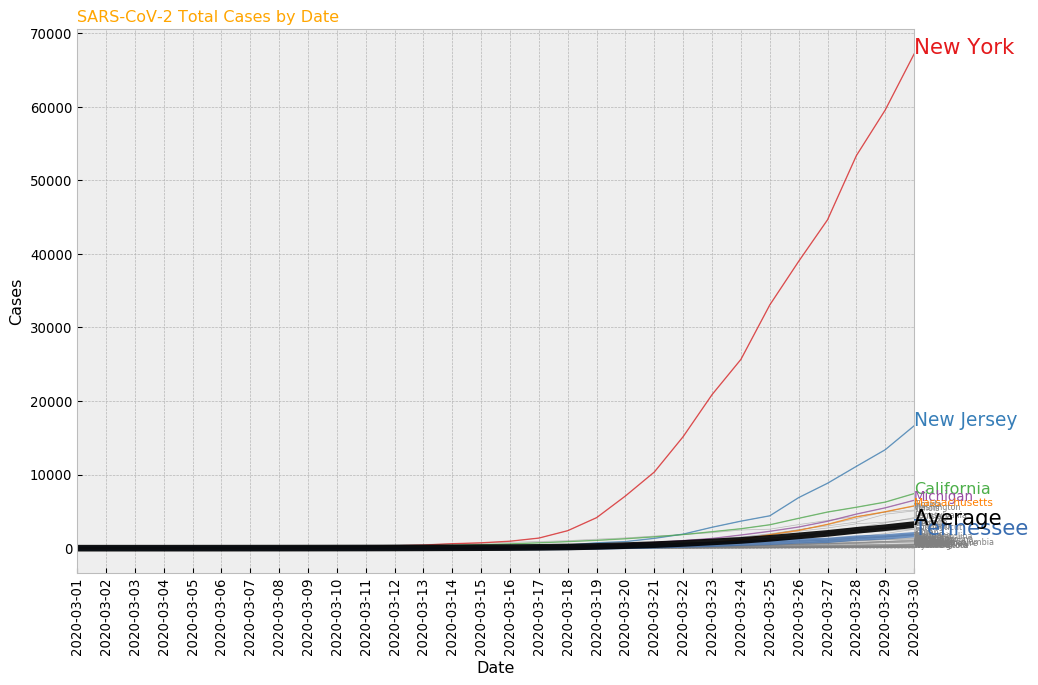

In [152]:
make_chart(df_total, "Tennessee", "SARS-CoV-2 Total Cases by Date")

## New Cases

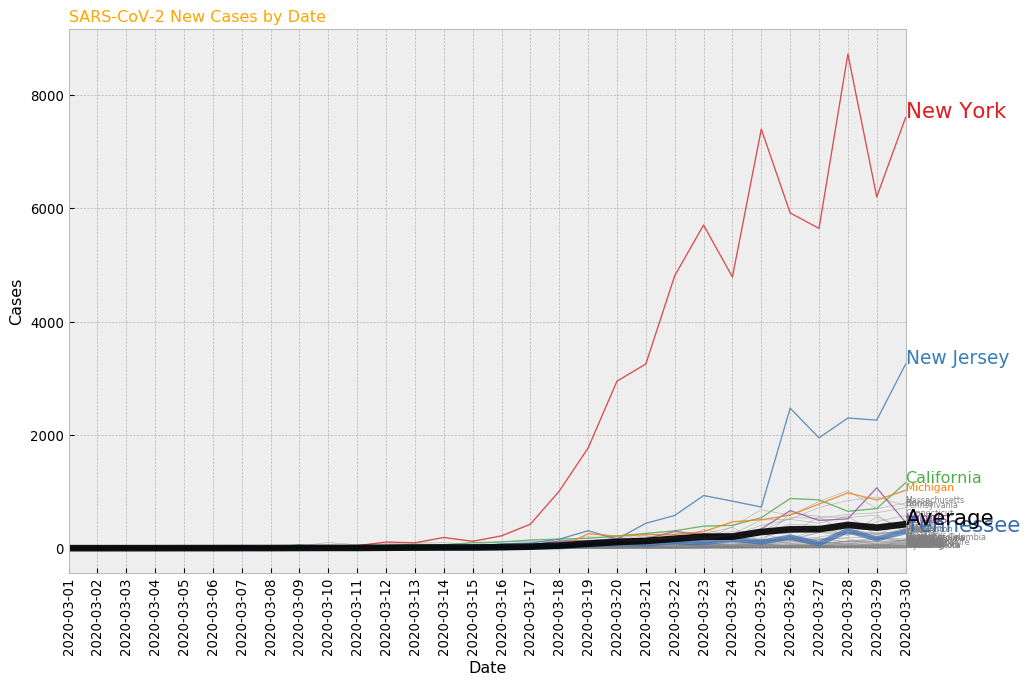

In [153]:
make_chart(df_delta, "Tennessee", "SARS-CoV-2 New Cases by Date")

## Total Cases per capita

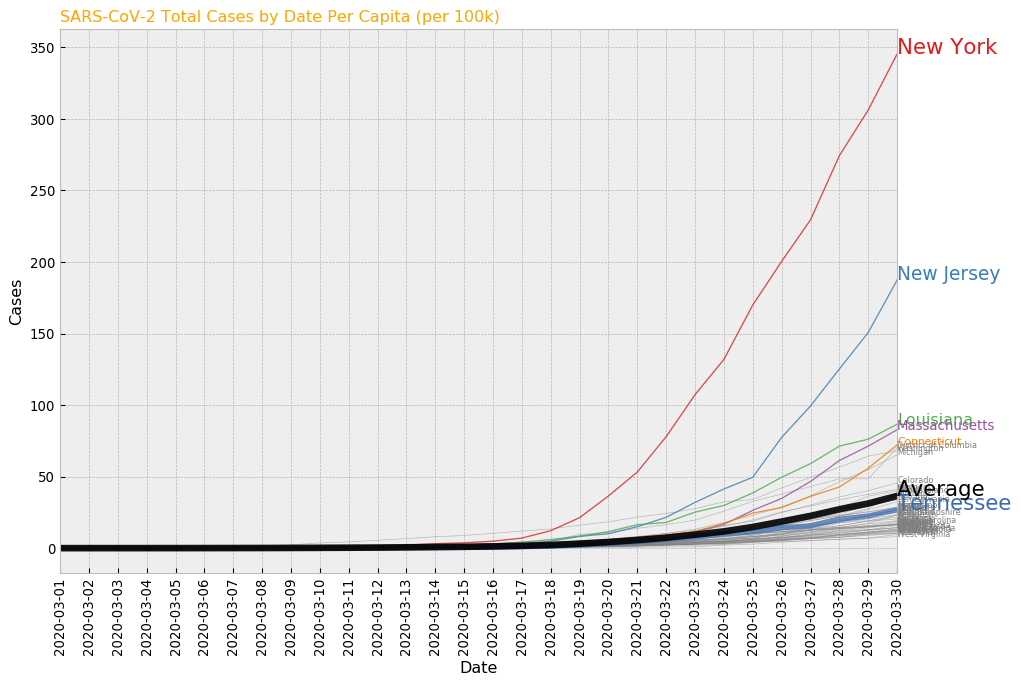

In [154]:
make_chart(df_total_percapita, "Tennessee", "SARS-CoV-2 Total Cases by Date Per Capita (per 100k)")

## New Cases per capita

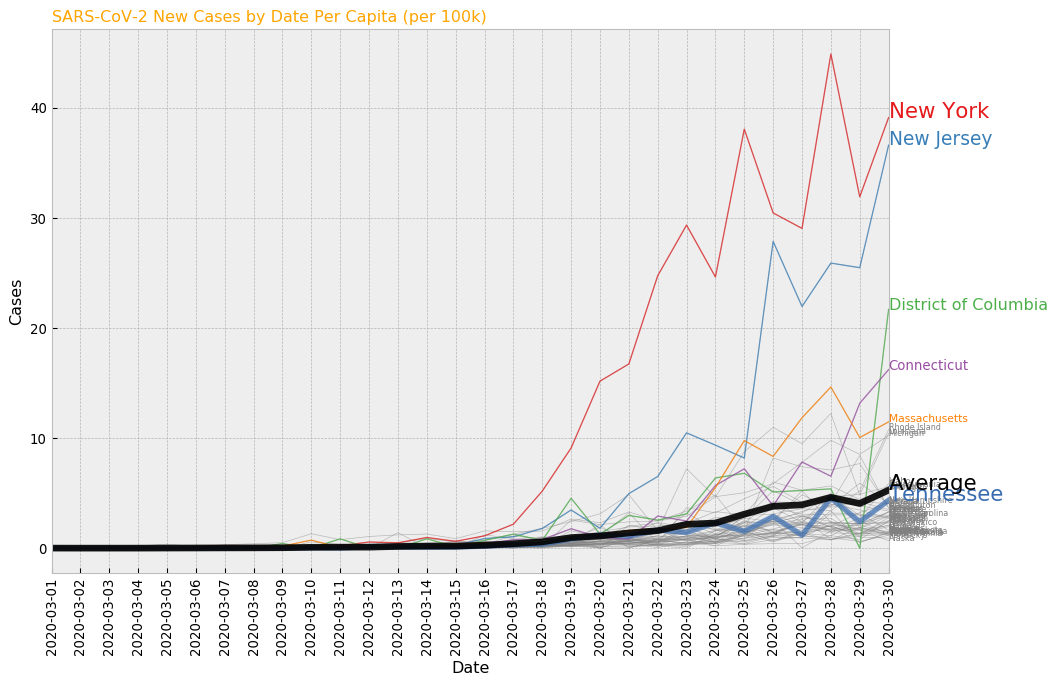

In [155]:
make_chart(df_delta_percapita, "Tennessee", "SARS-CoV-2 New Cases by Date Per Capita (per 100k)")

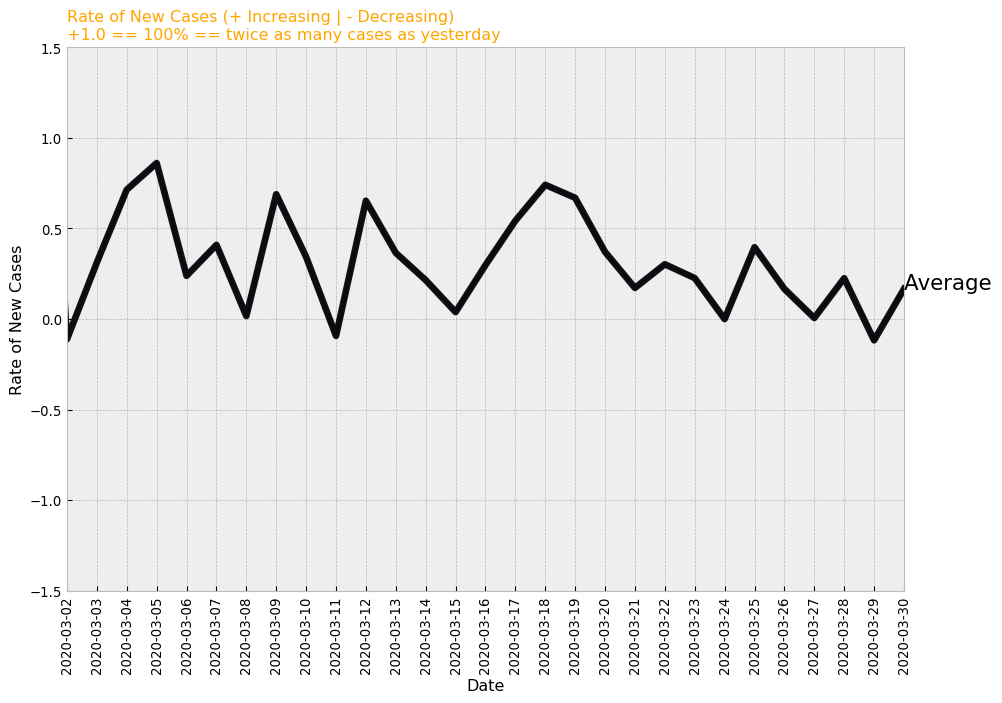

In [156]:
make_chart(df_delta_rate, "average", "Rate of New Cases (+ Increasing | - Decreasing)\n+1.0 == 100% == twice as many cases as yesterday ")

## Tennessee Data past 10 days

In [157]:
df["Tennessee"].tail(10)

60     312
61     424
62     522
63     679
64     784
65     981
66    1062
67    1373
68    1537
69    1834
Name: Tennessee, dtype: int64

In [158]:
df_delta["Tennessee"].tail(14)

56     21.0
57     25.0
58     57.0
59     82.0
60     75.0
61    112.0
62     98.0
63    157.0
64    105.0
65    197.0
66     81.0
67    311.0
68    164.0
69    297.0
Name: Tennessee, dtype: float64

In [159]:
# df_test = df_delta.copy()
# df_test.drop(["New York", "New Jersey"], axis=1, inplace=True)